In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../")

import numpy as np
from src.utils.visualize import plotMatrix

import matplotlib.pyplot as plt
# %matplotlib widget

In [56]:
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace

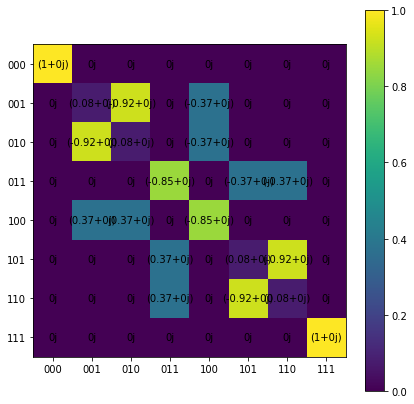

In [2]:
#using our same metrics as before using ratio of coupling strengths, investigate the relative costs of our 3Q gates
from src.hamiltonian import CirculatorHamiltonian
#v_nn = np.sqrt(2) * np.pi / np.arccos(1 / np.sqrt(3)) #w-state
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0]
#v_params = [np.pi / 2, np.pi / 2, np.pi / 2, np.pi / v_nn, np.pi / v_nn, np.pi / v_nn]
_array = CirculatorHamiltonian.construct_U(*v_params,t=1.6442677715360021) #w-state
#_array = CirculatorHamiltonian.construct_U(*v_params,t=1) #completed DIV
plotMatrix(_array);

In [35]:
#TODO XXX this code is written badly, needs to pass the entire circuit with a single parameter!!

In [38]:
from qiskit import transpile, BasicAer, QuantumCircuit
logger.setLevel(logging.WARNING)
def foo_plot2(v_params):
    data = []
    cost_data = []
    unit_cost = sum(v_params[-3:])/(np.pi/2) # XXX the g-terms
    t_range = np.linspace(0,1,20)
    for t_el in t_range:
        qc = QuantumCircuit(3)
        #qc.x(0)
        #qc.h(1)
        #qc.x(2)
        qc.x(1)
        unitary = CirculatorHamiltonian.construct_U(*v_params,t=t_el)
        qc.unitary(unitary, [0,1,2])
        #qc.rz(4*np.pi/3, 1)
        #qc.s(1)
        #qc.s(2)
        #qc.x(1)

        #output_state = np.matmul(unitary.full(),np.array(input_state))
        backend = BasicAer.get_backend('statevector_simulator') # the device to run on
        result = backend.run(transpile(qc, backend)).result()
        output_state = result.get_statevector(qc)

        data.append([np.abs(el)**2 for el in output_state])
        cost_data.append(unit_cost*t_el)
    for s_index in range(len(data[0])):
        temp_data = np.array(data).T[s_index]
        if any([el > 0 for el in temp_data]): 
            plt.plot(t_range, temp_data, label=r"$|$" + f"{bin(s_index)[2:].zfill(3)}" + r"$\rangle$", marker='.', dashes=(5, s_index))
    plt.plot(t_range, cost_data)
    plt.legend()
    plt.xlabel("Unitary duration (t)")
    plt.ylabel("State Probability")
    plt.ylim([0, 1])
    #plt.rcParams["figure.figsize"] = (12,8)
    print("final state:",data[-1])
    return qc

The Delta-iSwap is difficult to find entangled states for. Here is a costly GHZ-state:

final state: [0.4999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4999999999999999]


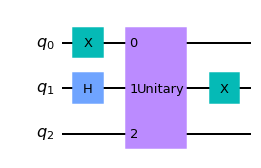

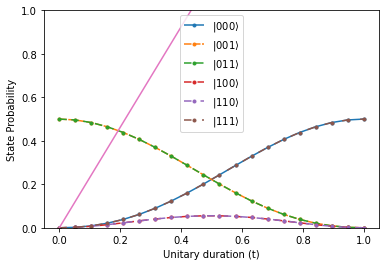

In [26]:
nn = 3 * np.sqrt(3) / 2
v_params = [np.pi / 2, -np.pi / 2, np.pi / 2, np.pi / nn, np.pi / nn, np.pi / nn]   #smiley
foo_plot2(v_params).draw(output='mpl')

Here is a Delta-iSwap finding the W-state from Martinis paper

final state: [0.0, 0.22222222222222227, 0.5555555555555554, 0.0, 0.22222222222222232, 0.0, 0.0, 0.0]


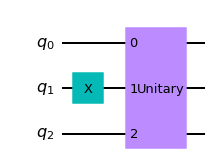

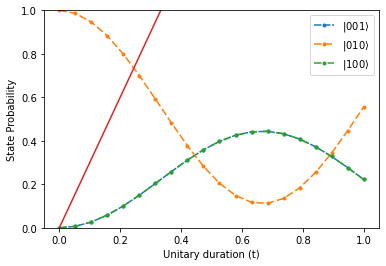

In [40]:
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [0, 0, 0, np.pi/2, np.pi/2, np.pi/2]
foo_plot2(v_params).draw(output='mpl')

The following V-iSwap gate is an interesting example because it shows both the W-State and the ~~GHZ-state created from the same input~~. My mistake, I saw 2 states go to equal probability, but this is not enough for a GHZ-state, needs to be |000> and |111> states specifically!

final state: [0.0, 0.5000000000000001, 0.5000000000000001, 0.0, 0.0, 0.0, 0.0, 0.0]


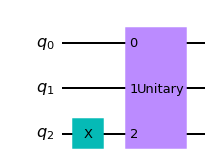

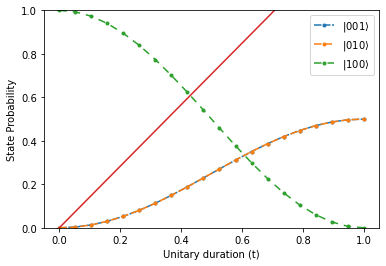

In [31]:
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
foo_plot2(v_params).draw(output='mpl')

It is difficult to know when we have the most cost-effective construction of an entangled state. A way to approach this problem differently, is to instead start with an entangled state, and run the gate while plotting mutual information - which should be 0 for a non-entangled state. This way we can observe states independent of 1Q gates, but by a pure measure of entanglement.

In [89]:
"""Use plots of mutual information to determine entanglement"""
#Idea: run the gate in reverse, and when mutual information is 0, no longer entangled
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
qc = QuantumCircuit(3)

from qiskit import transpile, BasicAer, QuantumCircuit
logger.setLevel(logging.WARNING)
def foo_plot3(v_params):
    data = []
    cost_data = []
    unit_cost = sum(v_params[-3:])/(np.pi/2) # XXX the g-terms
    t_range = np.linspace(0,1,20)
    for t_el in t_range:
        qc = QuantumCircuit(3)
        # #GHZ-state prep
        qc.h(0)
        qc.cx(0, 1)
        qc.cx(0, 2)
        #######

        #W-state prep
        # qc.ry(2*np.arccos(1/np.sqrt(3)),0)
        # qc.ch(0,1)
        # qc.cx(1,2)
        # qc.cx(0,1)
        # qc.x(0)
        #####

        unitary = CirculatorHamiltonian.construct_U(*v_params,t=t_el)
        qc.unitary(unitary, [0,1,2])
        
        state = Statevector(qc)
        state1 = partial_trace(state, [0])
        state2 = partial_trace(state, [1])
        state3 = partial_trace(state, [2])
        
        data.append([mutual_information(state1), mutual_information(state2), mutual_information(state3)])
        cost_data.append(unit_cost*t_el)
    for s_index in range(len(data[0])):
        temp_data = np.array(data).T[s_index]
        if any([el > 0 for el in temp_data]): 
            plt.plot(t_range, temp_data, label=f"S{s_index}", marker='.', dashes=(5, s_index))
    plt.plot(t_range, cost_data)
    plt.legend()
    plt.xlabel("Unitary duration (t)")
    plt.ylabel("Partial Trace Mutual Info")
    #plt.ylim([0, 1])
    #plt.rcParams["figure.figsize"] = (12,8)
    print("final state:",data[-1])
    return qc

# backend = BasicAer.get_backend('statevector_simulator')
# result = backend.run(transpile(qc, backend)).result()
# output_state = result.get_statevector(qc)
# print(output_state)

# qc.measure_all()
# from qiskit.visualization import plot_histogram
# backend = BasicAer.get_backend('qasm_simulator')
# job = execute(qc, backend)
# plot_histogram(job.result().get_counts())

This plot shows at ~.6, the mutual informations all go to 1, this is where the W-state is created by this gate.

final state: [0.0, 0.0, 1.9999999999999996]


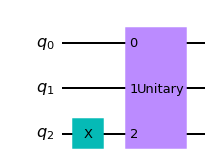

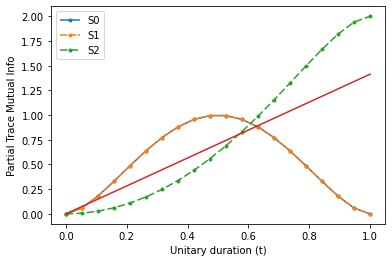

In [81]:
# foo_plot3(v_params) #GHZ state has this messy result
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
foo_plot3(v_params).draw(output='mpl')

Now we see the gate nevers undoes the entangled GHZ state.

final state: [1.0, 1.0, 1.0]


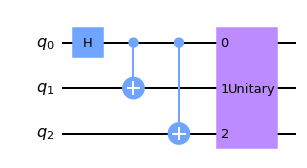

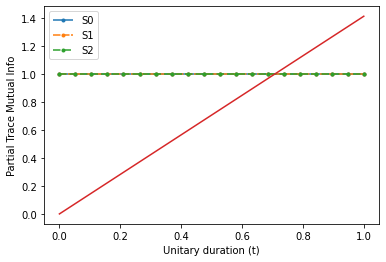

In [83]:
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
foo_plot3(v_params).draw(output='mpl')

But we can see it undo the entangled W-state! 

final state: [0.9182958340544894, 0.9182958340544889, 0.3817490092422168]


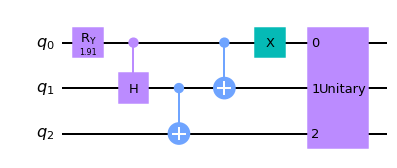

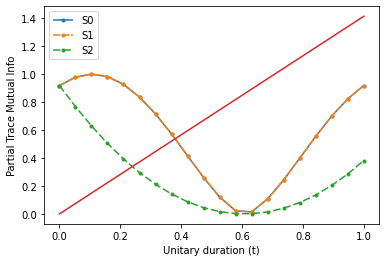

In [87]:
# foo_plot3(v_params) #GHZ state has this messy result
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
foo_plot3(v_params).draw(output='mpl')

Now let's revisit the delta-iswap, CPS gate we couldn't find a cheaper GHZ state for. This should undo the GHZ entanglement, but it doesn't - that means this method isn't as robust to 1Q fixes as originally thought it would be??

final state: [1.0000000000000002, 1.0000000000000002, 1.0000000000000002]


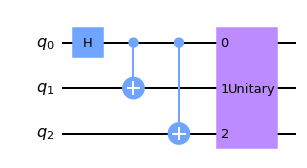

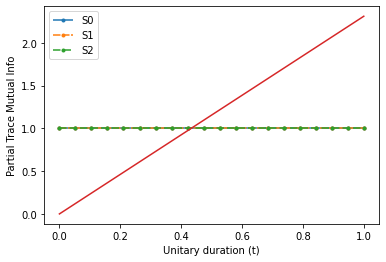

In [91]:
nn = 3 * np.sqrt(3) / 2
v_params = [np.pi / 2, -np.pi / 2, np.pi / 2, np.pi / nn, np.pi / nn, np.pi / nn]   #smiley
foo_plot3(v_params).draw(output='mpl')